# Vegetation Phenology

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
[crop_mask](https://explorer.digitalearth.africa/products/crop_mask)

## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects).

## Matt's suggestions

- Start a fresh notebook
- Use the shapefile and geopandas parts above to makea geopandas Dataframe of points, and cooresponding polygon
- Start a dask LocalCluster
- Datacube load for the bounds of the polygon = `data`
- for each point in the geopandas dataframe,
   - get the timeseries for the point from `data`, e.g. using `data.sel(latitude=lat, longitude=lon)`. See https://docs.xarray.dev/en/stable/user-guide/indexing.html
   - plot or do something with each timeseries

# Update on 29 Oct 2024 - Yingying
Due to the missing data in 2022 in `sentinel_2_c1_l2a` product, the previous product `s2_l2a are used.\
This script is to examine scaling factors, offsets, and data differences of two data products

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os, sys
from datetime import datetime


import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils.rio import configure_s3_access
from datacube.utils.geometry import Geometry
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from mpl_toolkits.axes_grid1 import host_subplot

repo1 = '/home/jovyan/easi-notebooks'
if repo1 not in sys.path: sys.path.append(repo1)

os.environ['USE_PYGEOS'] = '0'
from easi_tools import EasiDefaults, notebook_utils
easi = EasiDefaults()

repo = '/home/jovyan/deafrica-sandbox-notebooks/Tools'
if repo not in sys.path: sys.path.append(repo)

from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology

Successfully found configuration for deployment "asia"


In [2]:
import rioxarray as rio
import seaborn as sns

## Dask computing environment

In EASI, each notebook starts by defining a Dask cluster for the notebook to use.

> For more information regarding Dask, see [A2 - Dask](A2%20-%20Dask.ipynb).

The are two main methods for setting up your dask cluster: 
1. **Local dask cluster**
    - Provides a dask multiprocessing environment on your Jupyter node. Useful for processing data volumes that don't exceed the Jupyter node limits, which are currently set at `cores = 8, memory = 32 GB` (2x large)


1. **Dask Gateway**
    - Provides a scalable compute cluster in EASI for your use. You can (*should*) use the same cluster across each of your notebooks (a separate cluster per notebook would unnessarily use EASI resources).
    - For most notebooks and data analysis start with `2 to 4 workers` (adaptive). Dask gateway is limited to 20 workers per user.
    - It is normal for this step to take **3 to 5 minutes** if new computing nodes need to be generated

**This notebook will just use a local cluster**

### Dask cluster

For local cluster options, see https://docs.dask.org/en/latest/setup/single-distributed.html

The Dask Dashboard link shown after the following cell is a helpful resource to explore the activity and state of your dask cluster.

In [3]:
# cluster, client = notebook_utils.initialize_dask(use_gateway=False)
# display(cluster if cluster else client)
# print(notebook_utils.localcluster_dashboard(client, server=easi.hub))

# Use EASI 'dask gateway' cluster
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,5))
display(client)

Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.1bbf19f282ec4d88a9f2278788a5db14/status,


2024-10-29 00:53:52,180 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="Vegetation_phenology")
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`.
* `lat`: The central latitude to analyse (e.g. `24.35`).
* `lon`: The central longitude to analyse (e.g. `88.4`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2022-10', '2023-04')`).

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 24.35`, `lon = 88.4`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the EASI by draging and dropping files to the Jupyter Notebook File Browser (left side) . ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [5]:
# Set the vegetation proxy to use
veg_proxy = "NDVI"
time_range = ("2020-10-01", "2021-04-30")  # commoon periods between two products

In [6]:
# Method 2: Use a polygon as a GeoJSON or Esri Shapefile.
gdf = gpd.read_file('/home/jovyan/EASI_Bangladesh/input_data/lentil_22-23.shp') #/home/jovyan/input_data/lentil_22-23.shp
geopolygon_gdf = gpd.GeoDataFrame(geometry=[gdf.unary_union.convex_hull], crs=gdf.crs)

# Get the latitude and longitude range of the geopolygon
buffer = 0.001  # approximate 100 m
lat_range = (geopolygon_gdf.total_bounds[1]-buffer, geopolygon_gdf.total_bounds[3]+buffer)
lon_range = (geopolygon_gdf.total_bounds[0]-buffer, geopolygon_gdf.total_bounds[2]+buffer)

/tmp/ipykernel_832/3284219426.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geopolygon_gdf = gpd.GeoDataFrame(geometry=[gdf.unary_union.convex_hull], crs=gdf.crs)


In [7]:
lat_range, lon_range

((24.3862745, 24.4360797), (88.3965147, 88.47943120000001))

In [8]:
display(geopolygon_gdf)
display(gdf)

,geometry
0,"POLYGON ((88.46732 24.38727, 88.44501 24.39276..."


,start,latitude,longitude,Yield(t/ha,geometry
0,2023-02-28,24.425337,88.413161,0.898200,POINT (88.41316 24.42534)
1,2023-02-28,24.425380,88.412949,0.898200,POINT (88.41295 24.42538)
2,2023-03-05,24.408209,88.463824,0.898200,POINT (88.46382 24.40821)
3,2023-03-05,24.408758,88.463470,0.748500,POINT (88.46347 24.40876)
4,2023-03-05,24.408059,88.462607,1.047900,POINT (88.46261 24.40806)
...,...,...,...,...,...
198,2023-04-27,24.410867,88.424580,1.085325,POINT (88.42458 24.41087)
199,2023-04-27,24.410865,88.424590,0.935625,POINT (88.42459 24.41087)
200,2023-04-27,24.410040,88.424343,0.973050,POINT (88.42434 24.41004)
201,2023-04-27,24.409848,88.424048,0.860775,POINT (88.42405 24.40985)


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [9]:
display_map(x=lon_range, y=lat_range)

# Load dataset

In [9]:
time_range = ("2020-10-01", "2021-04-30")  # commoon periods between two products

## Uses the older (collection 0) S2 L2A
example notebook: https://github.com/csiro-easi/easi-notebooks/blob/main/notebooks/data_products/sentinel-2-l2a.ipynb
>**Apply the correct offset to the source data**
>
>ESA introduced a change to their L1C processing that encodes their L1C and L2A products with an offset value such that phyiscal_value = encoded_value * scale_factor + offset
>
>The cloud data custodian for ESA's S2-L2A data additionally may have pre-applied the offset or not to the data that we index and load. This introduces an inconsistency in the S2A series that we need to account for.
>
>We provide a convenience function `load_s2l2a_with_offset` to load s2_l2a data, apply the scale (and offset if required) and return an xarray.Dataset. This replaces datacube.load() for this product.

In [10]:
from easi_tools.load_s2l2a import load_s2l2a_with_offset

query = dict(
    product = 's2_l2a',
    x = lon_range,
    y = lat_range,
    time = time_range
)
output_crs = notebook_utils.mostcommon_crs(dc, query)
load_params = dict(
    output_crs = output_crs,
    resolution = (-10, 10),
    dask_chunks = {'x':2048, 'y':2048},
    group_by = 'solar_day'
)
data_old = load_s2l2a_with_offset(
    dc,
    query | load_params   # Combine the two dicts that contain our search and load parameters
)
display(data_old)
notebook_utils.xarray_object_size(data_old)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset> Size: 1GB
Dimensions:      (time: 41, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 328B 2020-10-01T04:51:49.079000 ... 20...
  * y            (y) float64 4kB 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 7kB 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 4B 32645
Data variables: (12/15)
    coastal      (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    blue         (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    green        (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    red          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge1     (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge2     (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    ...           ...
    nir09        (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    swir16       (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    swir22       (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    scl          (time, y, x) uint8 20MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    aot          (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    wvp          (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
Attributes:
    crs:           EPSG:32645
    grid_mapping:  spatial_ref

'Dataset size: 985.88 MB'

## Uses the new Collection 1 L2A
example notebook: https://github.com/csiro-easi/easi-notebooks/blob/main/notebooks/data_products/sentinel-2-c1-l2a.ipynb

In [11]:
query = dict(
    product = 'sentinel_2_c1_l2a',
    x = lon_range,
    y = lat_range,
    time = time_range
)
output_crs = notebook_utils.mostcommon_crs(dc, query)
load_params = dict(
    output_crs = output_crs,
    resolution = (-10, 10),
    dask_chunks = {'x':2048, 'y':2048},
    group_by = 'solar_day',
    skip_broken_datasets = True,
)
data_new = dc.load(**(query | load_params))
display(notebook_utils.xarray_object_size(data_new))

'Dataset size: 576.65 MB'

In [12]:
data_new

<xarray.Dataset> Size: 605MB
Dimensions:      (time: 41, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 328B 2020-10-01T04:51:49.079000 ... 20...
  * y            (y) float64 4kB 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 7kB 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 4B 32645
Data variables: (12/17)
    coastal      (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    blue         (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    green        (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    red          (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge1     (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge2     (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    ...           ...
    swir22       (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    cloud        (time, y, x) uint8 20MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    snow         (time, y, x) uint8 20MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    scl          (time, y, x) uint8 20MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    aot          (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    wvp          (time, y, x) uint16 39MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
Attributes:
    crs:           EPSG:32645
    grid_mapping:  spatial_ref

In [13]:
# Apply valid data mask
# valid_mask = masking.valid_data_mask(data)
# ds = data.where(valid_mask)
good_pixel_flags = ['vegetation', 'not vegetated', 'water'] # [flags_def[str(i)] for i in [4, 5, 6]]
good_pixel_mask = enum_to_bool(data_new.scl, good_pixel_flags)
ds = data_new.where(good_pixel_mask)  # Apply good pixel mask (to all measurement layers)

# Apply scale and offset
# Matt says: Something odd in our setup .. offset=0 in the STAC record but offset=-0.1 in the product def
measurement_info = dc.list_measurements().loc[query['product']]

In [14]:
measurement_info

,name,dtype,units,nodata,flags_definition,aliases,add_offset,scale_factor
measurement,,,,,,,,
coastal,coastal,uint16,1,0.0,NaN,"[band_01, B01, coastal_aerosol]",-0.1,0.0001
blue,blue,uint16,1,0.0,NaN,"[band_02, B02]",-0.1,0.0001
green,green,uint16,1,0.0,NaN,"[band_03, B03]",-0.1,0.0001
red,red,uint16,1,0.0,NaN,"[band_04, B04]",-0.1,0.0001
rededge1,rededge1,uint16,1,0.0,NaN,"[band_05, B05, red_edge_1]",-0.1,0.0001
rededge2,rededge2,uint16,1,0.0,NaN,"[band_06, B06, red_edge_2]",-0.1,0.0001
rededge3,rededge3,uint16,1,0.0,NaN,"[band_07, B07, red_edge_3]",-0.1,0.0001
nir,nir,uint16,1,0.0,NaN,"[band_08, B08, nir_1]",-0.1,0.0001
nir08,nir08,uint16,1,0.0,NaN,"[band_8a, B8A, nir_2]",-0.1,0.0001


In [15]:
for vv in ds.data_vars:
    scale = measurement_info.loc[vv,'scale_factor']
    # offset = 0 # measurement_info.loc[vv,'add_offset']        ########### Q: Why is the constant '0' used instead of the actual value '-0.1' in the product?
    offset = measurement_info.loc[vv,'add_offset']
    if not pd.isnull(scale) and not pd.isnull(offset):
        # print(f'{vv}: {scale}, {offset}')
        ds[vv] = ds[vv] * scale + offset
        
display(ds)

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 41, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 328B 2020-10-01T04:51:49.079000 ... 20...
  * y            (y) float64 4kB 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 7kB 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 4B 32645
Data variables: (12/17)
    coastal      (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    blue         (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    green        (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    red          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge1     (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge2     (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    ...           ...
    swir22       (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    cloud        (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    snow         (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    scl          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    aot          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    wvp          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
Attributes:
    crs:           EPSG:32645
    grid_mapping:  spatial_ref

# Index selection
- NDVI
- EVI
- SWI, Sentinel water index, https://www.mdpi.com/1147112
> **SWI = (ρVRE1 - 𝜌𝑆𝑊𝐼𝑅2)/(ρVRE1 + 𝜌𝑆𝑊𝐼𝑅2)**, represents the Sentinel-2 water index, ρVRE1
 represents the VRE1 band (`Band 5 (rededge1)` of the Sentinel-2 imagery), and  𝜌𝑆𝑊𝐼𝑅2
 represents the SWIR2 band (`Band 12 (swir22)` of the Sentinel-2 imagery).
> - The mean value of the SWI for the water types ranges from 0.78 to 0.89
> - The mean value of the SWI for the nonwater types ranges fromfrom −0.18 to −0.09

## using the new collection to calculate NDVI and EVI

In [16]:
# Calculate NDVI and EVI
# Borrowed from calculate_indices(ds, index=veg_proxy, satellite_mission="s2")

ndvi_da = (ds.nir - ds.red) / (ds.nir + ds.red)
evi_da = 2.5 * ((ds.nir - ds.red) / (ds.nir + 6 * ds.red - 7.5 * ds.blue + 1))
swi_da = (ds.rededge1 - ds.swir22) /(ds.rededge1 + ds.swir22)

veg = ndvi_da.to_dataset(name='ndvi')
veg['evi'] = evi_da
veg['swi'] = swi_da

display(veg)

<xarray.Dataset> Size: 234MB
Dimensions:      (time: 41, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 328B 2020-10-01T04:51:49.079000 ... 20...
  * y            (y) float64 4kB 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 7kB 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 4B 32645
Data variables:
    ndvi         (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    evi          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    swi          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>

In [17]:
%%time
veg_new = veg.compute()

CPU times: user 302 ms, sys: 273 ms, total: 575 ms
Wall time: 1min 22s


In [18]:
veg_new['ndvi'].max(), veg_new['ndvi'].min()

(<xarray.DataArray 'ndvi' ()> Size: 4B
 array(1.0542587, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32645,
 <xarray.DataArray 'ndvi' ()> Size: 4B
 array(-1.8765438, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32645)

## using the older (collection 0) to calculate NDVI and EVI

In [19]:
ndvi_da = (data_old.nir - data_old.red) / (data_old.nir + data_old.red)
evi_da = 2.5 * ((data_old.nir - data_old.red) / (data_old.nir + 6 * data_old.red - 7.5 * data_old.blue + 1))
swi_da = (data_old.rededge1 - data_old.swir22) /(data_old.rededge1 + data_old.swir22)

veg_old = ndvi_da.to_dataset(name='ndvi')
veg_old['evi'] = evi_da
veg_old['swi'] = swi_da

display(veg_old)

<xarray.Dataset> Size: 234MB
Dimensions:      (time: 41, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 328B 2020-10-01T04:51:49.079000 ... 20...
  * y            (y) float64 4kB 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 7kB 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 4B 32645
Data variables:
    ndvi         (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    evi          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    swi          (time, y, x) float32 78MB dask.array<chunksize=(1, 561, 848), meta=np.ndarray>

In [20]:
%%time
veg_old = veg_old.compute()

CPU times: user 343 ms, sys: 178 ms, total: 522 ms
Wall time: 54.9 s


In [21]:
veg_old['ndvi'].max(), veg_old['ndvi'].min()

(<xarray.DataArray 'ndvi' ()> Size: 4B
 array(0.99939126, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32645,
 <xarray.DataArray 'ndvi' ()> Size: 4B
 array(-0.9961315, dtype=float32)
 Coordinates:
     spatial_ref  int32 4B 32645)

# Examine the difference between two products

## simple stats

In [23]:
veg_diff = veg_new - veg_old

In [34]:
print(f"mean difference:{veg_diff['ndvi'].mean().item():.3f}, max difference:{veg_diff['ndvi'].max().item():.3f}, min difference:{veg_diff['ndvi'].min().item():.3f}")

mean difference:0.004, max difference:0.482, min difference:-0.382


## comparison plot

In [77]:
# select a few random points from Taslima's shapefile for testing
gdf_prj = gdf.to_crs(32645)
random_idx = [0, 2, 6, 8]

In [78]:
df_new = pd.DataFrame()
for idx, geom in zip(random_idx, gdf_prj.loc[random_idx, 'geometry']):
    df_temp = veg_new.sel(x = geom.x, y = geom.y, method = 'nearest').to_dataframe().drop(['x','y','spatial_ref'], axis = 1)
    df_temp['idx'] = idx
    df_temp['time'] = df_temp.index.date
    df_new = pd.concat([df_new, df_temp.reset_index(drop=True)], axis = 0)
df_new['product'] = 'sentinel_2_c1_l2a'
df_new = df_new.melt(id_vars = ['idx','time','product'], var_name = 'Index', value_name = 'Value')

In [79]:
df_old = pd.DataFrame()
for idx, geom in zip(random_idx, gdf_prj.loc[random_idx, 'geometry']):
    df_temp = veg_old.sel(x = geom.x, y = geom.y, method = 'nearest').to_dataframe().drop(['x','y','spatial_ref'], axis = 1)
    df_temp['idx'] = idx
    df_temp['time'] = df_temp.index.date
    df_old = pd.concat([df_old, df_temp.reset_index(drop=True)], axis = 0)
df_old['product'] = 's2_l2a'
df_old = df_old.melt(id_vars = ['idx','time','product'], var_name = 'Index', value_name = 'Value')

In [80]:
df_comb = pd.concat([df_new, df_old], axis= 0).reset_index(drop=True)

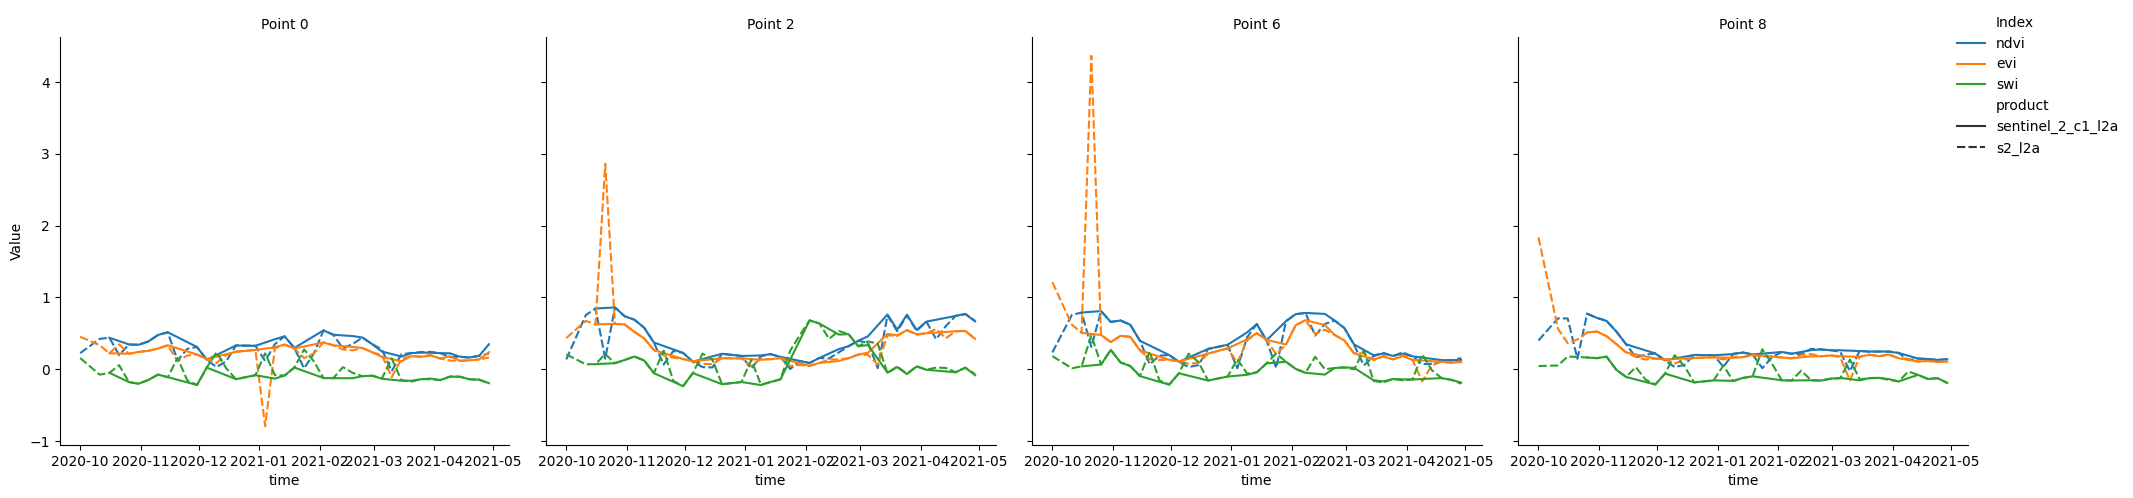

In [82]:
fig = sns.relplot(df_comb, x = 'time', y = 'Value', hue = 'Index', style = 'product', kind= 'line', col = 'idx', col_wrap=4)
fig.set_titles(col_template = 'Point '+'{col_name}')
sns.move_legend(fig, loc = 'upper left', bbox_to_anchor = (0.9,1))

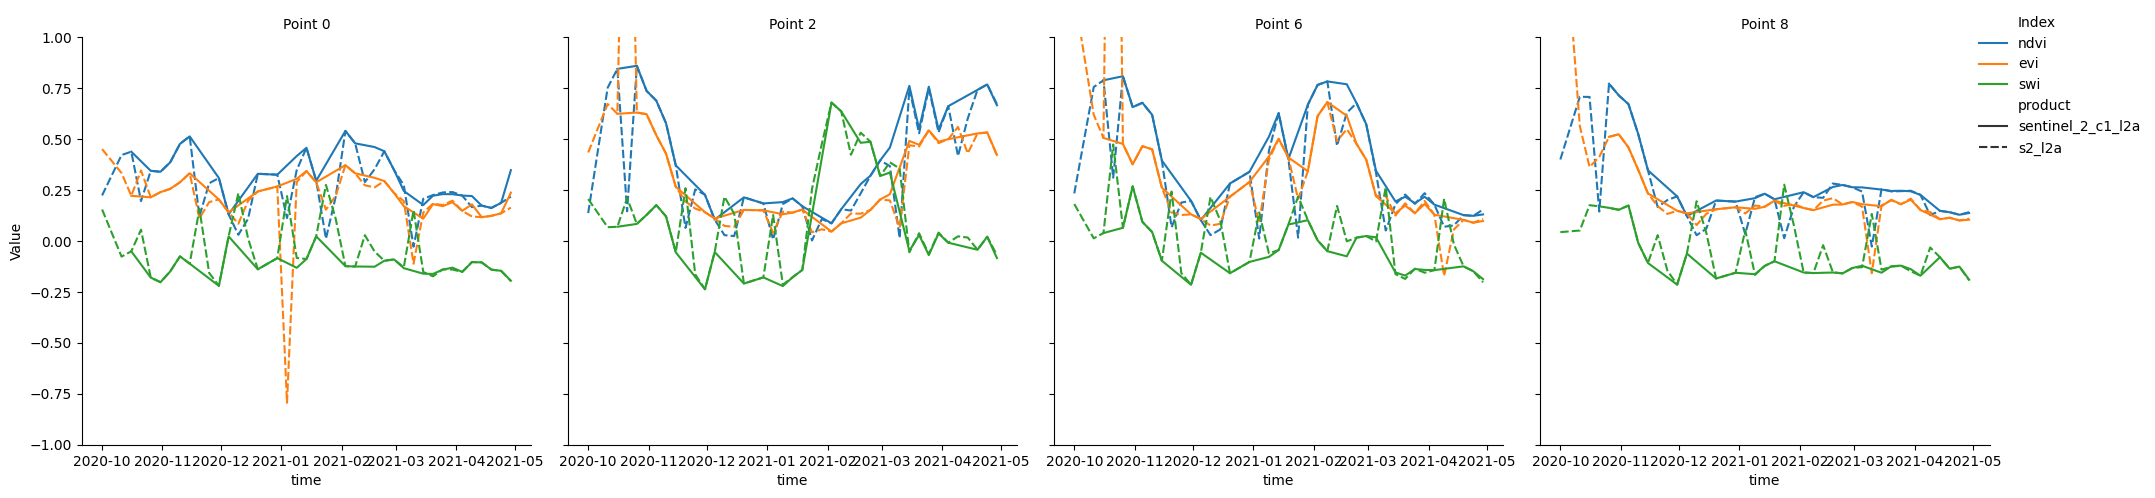

In [86]:
fig = sns.relplot(df_comb, x = 'time', y = 'Value', hue = 'Index', style = 'product', kind= 'line', col = 'idx', col_wrap=4)
fig.set_titles(col_template = 'Point '+'{col_name}')
fig.set(ylim=(-1, 1))
sns.move_legend(fig, loc = 'upper left', bbox_to_anchor = (0.9,1))

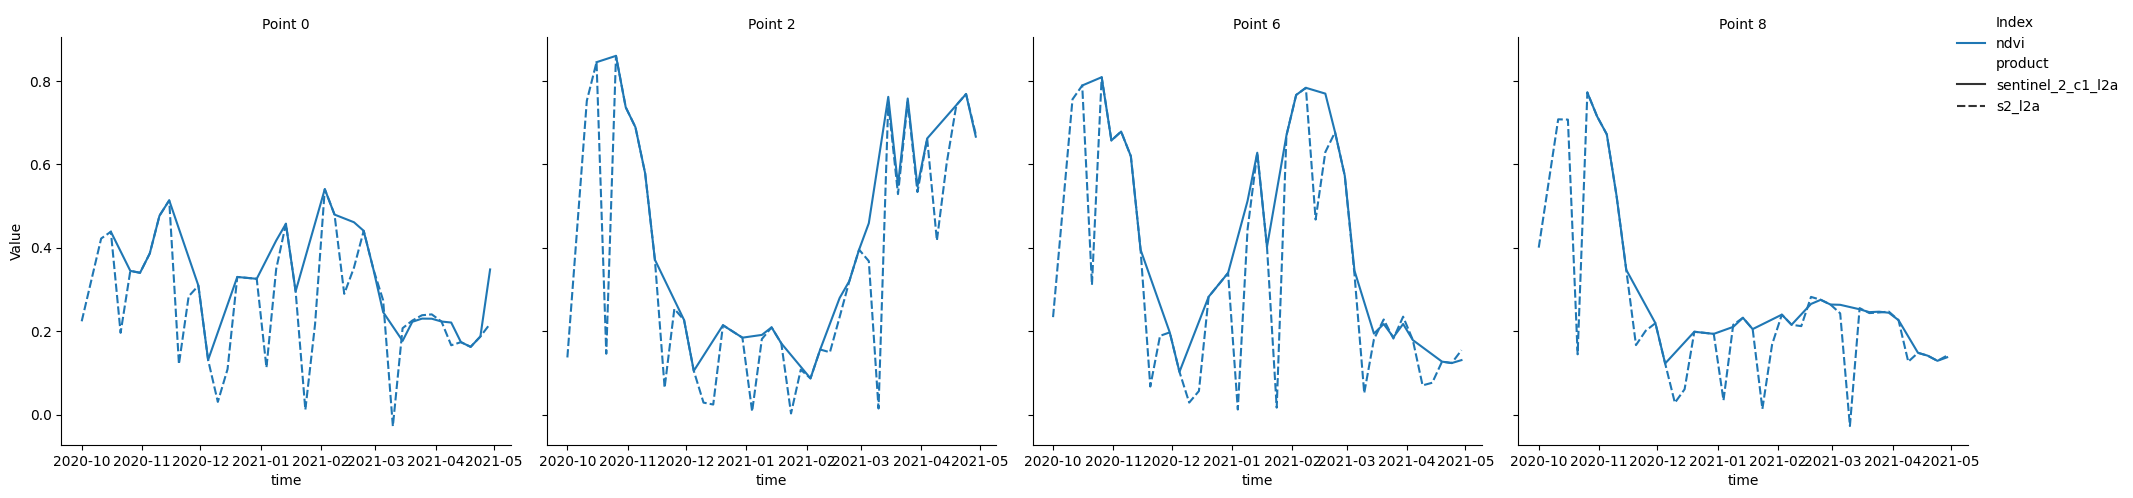

In [88]:
fig = sns.relplot(df_comb.query('Index=="ndvi"'), x = 'time', y = 'Value', hue = 'Index', style = 'product', kind= 'line', col = 'idx', col_wrap=4)
fig.set_titles(col_template = 'Point '+'{col_name}')
sns.move_legend(fig, loc = 'upper left', bbox_to_anchor = (0.9,1))